# Notebook to estimate performance of a DRT system for many different parameter constellations
- estimations bases on previous simulation of the shortest distance to connect n random points (in any order) within unit circle
- formula when drawing n (number of passengers) out z random bus stops (with equal probability) 

In [782]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import datetime

# 3D
from mpl_toolkits.mplot3d import Axes3D 

# monitor memory space utility
import os, psutil # os not needed

# for animations
from matplotlib.animation import FuncAnimation, PillowWriter


In [783]:
# helper functions

def flattenList(l, degree:int=1):
    """
    Helper function to flat list degree times
    """
    if n_iters == 0: return(l)
    return [item for sublist in flattenList(l, degree-1) for item in sublist]
#

def listProduct(ar_list):
    """
    Helper Function to create all possible combination of multiple lists
    """
    if not ar_list:
        yield ()
    else:
        for a in ar_list[0]:
            for prod in listProduct(ar_list[1:]):
                yield (a,)+prod
#

def multi_indexer_assigner(d:dict, indexer_arr:list, value):
        if len(indexer_arr)<2:
            d[indexer_arr[0]]=value
            return
        multi_indexer_assigner(d[indexer_arr.pop(0)], indexer_arr, value)
#

def multi_indexer(d_arr:dict, indexer_arr:list):
    """
    iterates through indexes and return final element in d_arr
    """
    return(d_arr[indexer_arr[0]] if len(indexer_arr)<2 else multi_indexer_assigner(d[indexer_arr[0]], indexer_arr[1:], value))
#

def param_items_to_str(item_list:list):
    return ' '.join([str(key)+':'+str(vals[0] if type(vals)==list else vals) for (key,vals) in item_list])
#

def scale_increaser(n:float, scale_items:list):
    for scale_factor, scale_unit in scale_items:
        if n<scale_factor:
            break 
        n = n/scale_factor
    return (n, scale_unit)
#

def print_scenario_estimation(n_combinations, total_memory:int=psutil.Process().memory_info().rss):
    """
    prints a guess of computing resources needed to compute scenario
     
    Inputs:
        - n_combinations: number of scenario combinations
        - total_memory: in byte

    does not include fact that base params (e.g number of passengers) increase the scenarios possibilites by more than e.g. vehicle velocity
    """
    time_est = 2+n_combinations*43.2/640000//1
    time_scale = [(60,'seconds'),(60,'minutes'),(24,'hours'),(7,'days'),(4.3,'weeks'),(12,'months'),(0,'years')]
    
    byte_est = 350*1e6/512000*n_combinations//1
    byte_scale = [(1e3, 'byte'),(1e3, 'kb'),(1e3, 'mb'),(1e3, 'gb'),(1e3, 'tb')]
    print("time_est, byte_est",time_est, byte_est)
    print( 'Number of scenario combinations:', n_combinations,
        '\nEstimated computing time:', scale_increaser(time_est, time_scale),
        '\nEstimated memory space usage:', scale_increaser(byte_est, byte_scale), ' equals' , byte_est/psutil.virtual_memory().total*1000//1/10, 'percent'
    )
#




In [784]:
# possible params:
n_stops_in_net = 50 # in h
n_pax = 12 # number of pax per tour OR average number of accepted request per hour OR average vehicle occupancy in h, pax leaves vehicle after travelling 10km
direct_trip_length = 8 # distance each passengers travels on average in kmh until leaving vehicle
stop_time_first_pax = 0.004165 # stop time when 1 passenger is boarding or alighting in h
stop_time_extra_pax = 0.001666 # stop time increase for each addtional passenger boarding or alighting in h
velocity = 30.0 # in km/h
n_vehicles = 1
vehicle_capacity = 8
vehicle_km_per_day = 160
maximum_tour_duration = 4.5# pausezeiten?
break_duration = 0.75 #

In [785]:
# Function to apply on scenario parameters


def vehicle_cost_calc(vehicle_capacity:int=vehicle_capacity, vehicle_km_per_day:float=vehicle_km_per_day)->tuple:
    """
    return tuple of 
        - total cost
        - dict of
            - vehicle fix cost per day in eur, 
            - vehicle km based cost in eur, 
            - personal cost per day in eur
            - personal cost share
    Inputs:
        - vehicle_capacity
        - km per day
    """
    fix_cost=(6+.042*vehicle_capacity*1.05**vehicle_capacity**.8) * 1000 / 365
    km_cost=(13+.15*vehicle_capacity*1.05**vehicle_capacity**.8 **.8) * 1000 * (vehicle_km_per_day / 75000)
    staff_cost=33.6 * 1000 / 365
    total_cost = fix_cost+km_cost+staff_cost
    # staff_cost_share should be: 0.48:26-38 seats, 0.39:39-55 seats, 0.38:26-38 seats # Tabelle 1: Kostenstrukturen spanischer Fernbusunternehmen in Abhängigkeit der Busgröße [MiFo13, S. 8, 12, 16] 
    return (total_cost, {'fix_cost':fix_cost, 'km_cost': km_cost, 'staff_cost':staff_cost, 'staff_cost_share':staff_cost/total_cost, 'marginal_cost_per_km':km_cost/vehicle_km_per_day})
#

staff_cost_share = vehicle_cost_calc()[1]['staff_cost_share']
#

def n_stops_on_path(n_pax:int=n_pax, n_stops_in_net:int=n_stops_in_net, stop_demand_fun=None) -> float:
    """
    returns expected number of unique stops rounded up to nearest int
    Inputs:
        - n_pax: number of individual passengers
        - n_stops_in_net: number of stops where pax could potentially picked up / dropped off 
    """
    # def ceil(f): return int(f//1+(f%1>0))
    # return ceil(n_stops_in_net*(1-((n_stops_in_net-1)/n_stops_in_net)**(2*n_pax)))
    return n_stops_in_net*(1-((n_stops_in_net-1)/n_stops_in_net)**(2*n_pax))
    # potentially let demand at each stop be drawn from distribution e.g. uniform(0-1)
#

##### TODO work on this functions. its decreasing too early.
def dist_total(n_stops_on_path:int=n_stops_on_path()) -> float:
    """
    return expected total travel distance
    Inputs:
        - n_stops_on_path: number of unique stops on path
    
    Function is an approximation to the resultion route length with respect of number of random points to connect within unit circle
    """
    return (1.2*(n_stops_on_path-1)/(n_stops_on_path**.5) + 0.1*n_stops_on_path - 0.0037*n_stops_on_path**1.7)*direct_trip_length
    #7*n_stops_on_path**0.2-0.05*n_stops_on_path+0.15*n_stops_on_path*0.99**n_stops_on_path-25
#

def stop_time_total(
        n_pax:int=n_pax, 
        n_stops_on_path:int=n_stops_on_path(), 
        stop_time_first_pax:float=stop_time_first_pax, 
        stop_time_extra_pax:float=stop_time_extra_pax
        ) -> float:
    """
    returns total stop time
    Inputs:
        - n_pax: number of individual passengers
        - n_stops_in_net: number of stops where pax could potentially picked up / dropped off 
    """
    return stop_time_first_pax/60/60*n_stops_on_path + stop_time_extra_pax/60/60*(2*n_pax-n_stops_on_path)
#

def share_driving_time(
        velocity:float=velocity,
        dist_total=dist_total(),
        stop_time_total=stop_time_total()
        ) -> float:
    """
    returns the share of time the vehicle is moving
    Inputs:
        - velocity: vehicle velocity when travelling
        - dist_total: total travel distance travelled to serve all pax
        - stop_time_total: total time stopping for boarding and alighting pax
    """
    # return dist_total/(dist_total+stop_time_total*velocity)
    return (dist_total/velocity)/(dist_total/velocity+stop_time_total)
#

def average_travel_speed(
        velocity:float=velocity,
        share_driving_time=share_driving_time()
        ) -> float:
    """
    returns the average travel speed of vehicle per operating hour
    Inputs:
        - velocity: vehicle velocity when travelling
    """
    # return dist_total/(dist_total/velocity+stop_time_total)
    return share_driving_time*velocity
#

def pax_served_per_hour(
        n_pax:int=n_pax, 
        velocity:float=velocity,
        dist_total=dist_total(),
        stop_time_total=stop_time_total()
        ) -> float:
    """
    returns the average travel speed of vehicle per operating hour
    Inputs:
        - velocity: vehicle velocity when travelling
        - dist_total: total travel distance travelled to serve all pax
        - stop_time_total: total time stopping for boarding and alighting pax
    """
    return n_pax/(dist_total/velocity+stop_time_total)
#

def pax_trip_time_average(
        dist_total=dist_total(),
        average_travel_speed=average_travel_speed()
        ) -> float:
    """
    returns the average travel speed of vehicle per operating hour
    Inputs:
        - velocity: vehicle velocity when travelling
        - dist_total: total travel distance travelled to serve all pax
        - stop_time_total: total time stopping for boarding and alighting pax
    """
    return dist_total/average_travel_speed
#


# store all in array.
all_kpi_funcs = [n_stops_on_path, dist_total, stop_time_total, share_driving_time, average_travel_speed, pax_served_per_hour, pax_trip_time_average]

    

In [786]:
# label dicts for var and functions

# ['n_stops_on_path', 'dist_total', 'stop_time_total', 'share_driving_time', 'average_travel_speed', 'pax_served_per_hour']
kpi_to_label = {
    'n_stops_on_path': 'Expeted number of distinct stops',
    'dist_total': 'Shortest path connecting all stops in km',
    'stop_time_total': 'Total bus time stop time mins',
    'share_driving_time': 'Driving time share of total operating time in %',
    'average_travel_speed': 'Av. speed of bus during operating time km/h',
    'pax_served_per_hour': 'Passengers served per hour',
    'pax_trip_time_average': 'Av. travel time per trip in h'
}

# ['n_pax', 'n_stops_in_net', 'direct_trip_length', 'stop_time_first_pax', 'stop_time_extra_pax', 'velocity', 'stop_demand_fun']
param_names_to_label = {
    'n_pax': 'Av. number of PAX per vehicle',
    'n_stops_in_net': 'Total number of stops',
    'direct_trip_length': 'Direct OD path in km',
    'stop_time_first_pax': 'Stop time for single PAX mins',
    'stop_time_extra_pax': 'Stop time for add PAX mins',
    'velocity': 'Free floating speed of vehicle',
    'stop_demand_fun': 'Demand distribution for stops',
}

key_to_label = dict(list(kpi_to_label.items())+list(param_names_to_label.items()))

In [787]:
def sci_params_generator(
        n_pax:list or int=[10], 
        n_stops_in_net:list or int=[100],
        direct_trip_length:list or float = [9.1],# distance each passengers travels on average in kmh until leaving vehicle
        stop_time_first_pax:list or float = [0.004165], # stop time when 1 passenger is boarding or alighting in h
        stop_time_extra_pax:list or float = [0.001666], # stop time increase for each addtional passenger boarding or alighting in h
        velocity:list or float = [30.0], # in km/h
        stop_demand_fun = [None],
)->dict:

        # ensure all params are provided within array
        param_name_to_sci_val = dict([(key, val if type(val)==list else [val]) for (key, val) in locals().items()])

        # estimation of computing times
        print_scenario_estimation(math.prod([len(x) for x in param_name_to_sci_val.values()]))

        return param_name_to_sci_val

In [788]:

def kpi_funcs_to_save_generator(
        run_kpi_list:list=None,#[n_stops_on_path, dist_total, stop_time_total, share_driving_time, average_travel_speed, pax_served_per_hour, pax_trip_time_average],
        all_kpi_funcs:dict=list(all_kpi_funcs)
)->dict:
    """
    retruns dict mapping kpi_func that need to be executed to whether the result should be saved True / False 
    Inputs: 
        - run_kpi_list: list of kpi_funcs provided directly or as string
        - all_kpi_funcs: that are defined at all. need to be provided as functions (not strings)
    """
    
    all_kpi_names = [kpi_func.__name__ for kpi_func in all_kpi_funcs]
    kpi_name_to_func = dict(zip(all_kpi_names, all_kpi_funcs))    

    if run_kpi_list == None:
        run_kpi_list = all_kpi_names
    else:
        # make sure all kpis are referenced by function not only name string
        run_kpi_list = [kpi_func_or_name if type(kpi_func_or_name)==str else kpi_func_or_name.__name__ for kpi_func_or_name in run_kpi_list]
    #

    # make sure that all functions that are inputs to other functions are listed
    # also return the correct order
    kpi_names_sorted = []
    
    unassigned_kpi_names = set(run_kpi_list)

    while len(unassigned_kpi_names)>0:
        all_missing_infl_kpis = set()
        assign_kpi_names = []
        # try to assign if they are good
        for kpi_name in unassigned_kpi_names:
            kpi_func = kpi_name_to_func[kpi_name]
            kpi_infl_kpis = set(kpi_func.__code__.co_varnames[:kpi_func.__code__.co_argcount]).intersection(all_kpi_names)
            missing_infl_kpis = kpi_infl_kpis.difference(kpi_names_sorted)

            if len(missing_infl_kpis)==0:
                assign_kpi_names.append(kpi_name)
            else:
                all_missing_infl_kpis.update(missing_infl_kpis)
            #
        #

        kpi_names_sorted.extend(assign_kpi_names)
        unassigned_kpi_names = unassigned_kpi_names.union(all_missing_infl_kpis).difference(assign_kpi_names)
    #
    return { kpi_name_to_func[kpi_name]: kpi_name in run_kpi_list for kpi_name in kpi_names_sorted }

# kpi_funcs_to_save_generator([n_stops_on_path, dist_total, stop_time_total, share_driving_time, average_travel_speed, pax_served_per_hour, pax_trip_time_average])
kpi_funcs_to_save_generator([stop_time_total, share_driving_time, average_travel_speed, pax_served_per_hour, pax_trip_time_average])

{<function __main__.n_stops_on_path(n_pax: int = 12, n_stops_in_net: int = 50, stop_demand_fun=None) -> float>: False,
 <function __main__.stop_time_total(n_pax: int = 12, n_stops_on_path: int = 19.210983174546087, stop_time_first_pax: float = 0.004165, stop_time_extra_pax: float = 0.001666) -> float>: True,
 <function __main__.dist_total(n_stops_on_path: int = 19.210983174546087) -> float>: False,
 <function __main__.share_driving_time(velocity: float = 30.0, dist_total=50.75446861005824, stop_time_total=2.4442290820330746e-05) -> float>: True,
 <function __main__.pax_served_per_hour(n_pax: int = 12, velocity: float = 30.0, dist_total=50.75446861005824, stop_time_total=2.4442290820330746e-05) -> float>: True,
 <function __main__.average_travel_speed(velocity: float = 30.0, share_driving_time=0.9999855528360154) -> float>: True,
 <function __main__.pax_trip_time_average(dist_total=50.75446861005824, average_travel_speed=29.999566585080462) -> float>: True}

In [789]:
kpi_funcs_ordered = [n_stops_on_path, dist_total, stop_time_total, share_driving_time, average_travel_speed, pax_served_per_hour, pax_trip_time_average]

def scenario_controller(
        param_name_to_sci_val:dict=sci_params_generator(),
        kpi_funcs_ordered = kpi_funcs_ordered,
        kpi_funcs_to_save = kpi_funcs_to_save_generator(),
        run:list or bool=True,
    )->list:
    """
    calls different scenario aspects and stores different results
    Inputs:
        - run: bool or list. If False then only number of compinations for scenario is returned. If True all aspects and functions are run. Or vector strings with of function names that should be exececuted
        - n_iterations
        - create_plots
        - n_pax: ??number of pax per tour OR average number of accepted request per hour OR average vehicle occupancy in h
        - n_stops_in_net: number of stops where pax could potentially picked up / dropped off 
        - direct_trip_length: length of direct path between origin and demand of any pax
        - stop_time_first_pax: stop time when 1 passenger is boarding or alighting in h
        - stop_time_extra_pax: stop time increase for each addtional passenger boarding or alighting in h
        - velocity: vehicle velocity in km/h when driving

    Abbreivations: sci: scenarios, sce: scenario, param: modifiable scenario parameter, 

    kpi_name and kpis should be renamed to what they actually are: they compute key indicators for given cenario
    """
    # unpack parameter dictionary for easier later reference
    param_name_vals_sci, all_param_names = list(param_name_to_sci_val.items()), list(param_name_to_sci_val.keys())

    if not run: # early return when not running to only print estimated time
        return

    # store list with names for later reference to avoid retrieving the name in nested loops
    kpi_funcs = kpi_funcs_to_save.keys()
    kpi_names = [kpi.__name__ for kpi in kpi_funcs_to_save.keys()]
    kpi_name_to_func = dict(zip(kpi_names, kpi_funcs)) 

    # for each kpi determine recursively what its direct function inputs and what its influential factors are
    kpi_to_infl_factors, kpi_to_direct_func_inputs = {}, {}
    for kpi_name, kpi_func in zip(kpi_names, kpi_funcs):
        kpi_direct_func_inputs = list(kpi_func.__code__.co_varnames[:kpi_func.__code__.co_argcount])
        kpi_to_direct_func_inputs[kpi_name] = kpi_direct_func_inputs

        # flatten once
        kpi_influences_unsorted_duplicated = [item for sublist in 
                [[param_or_kpi_name] if param_or_kpi_name in all_param_names else kpi_to_infl_factors[param_or_kpi_name] for param_or_kpi_name in kpi_direct_func_inputs] 
            for item in sublist]
        kpi_to_infl_factors[kpi_name] = sorted(list(set(kpi_influences_unsorted_duplicated)), key=all_param_names.index)
    #

    kpi_params_arr = [(kpi_name, sorted(list(set(all_param_names) & set(kpi_to_infl_factors[kpi_name])), key=all_param_names.index)) for kpi_name in kpi_names]
    kpi_items_arr = [(kpi_name, [(param_name, param_name_to_sci_val[param_name]) for param_name in param_names]) for (kpi_name, param_names) in kpi_params_arr]

    # memory error is likely as the results for all the function are held in memory at the same time
    # holding results for function for which the outputs are needed for later functions is however necessary
    # a way to prevent this is to generate a functional form that directly return the results with respect to influence parameters    
    kpi_to_out = dict([(kpi_name, {
        # param only refers to influencial factor for kpi # maybe rename. 
        'param_names': [param_name for (param_name,param_vals) in params_items], 
        'param_items': [(param_name,param_vals) for (param_name,param_vals) in params_items], 
        'param_names_to_vals': dict([(param_name,param_vals) for (param_name,param_vals) in params_items]), 
        'params_dim':[len(param_vals) for (param_name,param_vals) in params_items], 
        'params_val_to_kpi_val': {}
        }) for (kpi_name, params_items) in kpi_items_arr])

    # prepare all combinations to loop through # maybe there is a better way to do it.
    sci_params_flat = [[(param_name, param_val) for param_val in param_vals] for (param_name, param_vals) in param_name_vals_sci]
    # create all possible combs
    param_val_combs_sci = [dict(x) for x in listProduct(sci_params_flat)]

    
    # store interim results to quickly check whether functions needs to be applied or whether result is already computed. Allows for quick request of result
    infl_factors_vals_to_kpi_val = {}
    
    for sce in param_val_combs_sci:
        for kpi_name, kpi_fun in zip(kpi_names, kpi_funcs_to_save.keys()):
            # optain list of param_name, param_value pairs of given scenario that are influencial factor to current kpi
            sce_param_names_n_vals_infl_kpi = [(param_name, sce[param_name]) for param_name in kpi_to_out[kpi_name]['param_names']]
            # str used to store and retrieve interim result for a kpi for combination of influencial factor values
            param_str = param_items_to_str(sce_param_names_n_vals_infl_kpi)
            
            # if the current combination of values of influencial factor already used to compute current kpi, jump to next kpi
            if (kpi_name+'='+param_str) in infl_factors_vals_to_kpi_val.keys():
                continue
            
            # get input parameter values for kpi function
            # values are either simply taken from sce parameter or 
            # if they refere to a kpi that has already been computed, then the result needs to be looked up according to current sce params that influence the precomputed kpi  
            kpi_func_direct_inputs = [
                sce[param_or_kpi_name]
                    if param_or_kpi_name in all_param_names else 
                infl_factors_vals_to_kpi_val[
                    (param_or_kpi_name+'='+param_items_to_str([(param_name, sce[param_name]) for param_name in kpi_to_out[param_or_kpi_name]['param_names']]))
                ] 
                for param_or_kpi_name in kpi_to_direct_func_inputs[kpi_name]
            ]
            # unpack input parameters to execute function and optain kpi value
            kpi_val = kpi_fun(*kpi_func_direct_inputs)
            # store as intermediate result
            infl_factors_vals_to_kpi_val[(kpi_name+'='+param_str)] = kpi_val
            # store in final result dictonary
            if kpi_funcs_to_save[kpi_name_to_func[kpi_name]]==True:
                kpi_to_out[kpi_name]['params_val_to_kpi_val'][param_str] = kpi_val
        #
    #
    
    # return dictionary with results
    return {
        'kpi_to_out': kpi_to_out, 
        # 'param_name_vals_sci': param_name_vals_sci, 
        'param_name_to_sci_val': param_name_to_sci_val,
        # 'param_val_combs_sci': param_val_combs_sci,
        }
#


time_est, byte_est 2.0 683.0
Number of scenario combinations: 1 
Estimated computing time: (2.0, 'seconds') 
Estimated memory space usage: (683.0, 'byte')  equals 0.0 percent


In [790]:
param_name_to_sci_val = sci_params_generator(
    n_pax=[int(x) for x in np.linspace(1,80,40)], #(1,80,80)
    n_stops_in_net=[int(x) for x in np.linspace(20, 400, 10)],#(10, 200, 20)
    velocity=[x for x in np.linspace(24, 50, 4)], #(24, 50, 13)
    direct_trip_length=[x for x in np.linspace(9.1, 9.1, 1)], #(6, 13.5, 6)
    stop_time_first_pax=[x for x in np.linspace(20, 60, 11)],#(0.25, 1, 20)
    stop_time_extra_pax= [x for x in np.linspace(2, 10, 9)]#(2/60, 10/60, 9)
    )

sci_kpis = scenario_controller(
    run=True, 
    param_name_to_sci_val=param_name_to_sci_val,
    kpi_funcs_to_save = kpi_funcs_to_save_generator()
)

# filename
path, filename, ext = './scenarios/', 'sc_04_29', '.npy'

time_est, byte_est 12.0 108281250.0
Number of scenario combinations: 158400 
Estimated computing time: (12.0, 'seconds') 
Estimated memory space usage: (108.28125, 'mb')  equals 1.2 percent


In [791]:
# saving does not work

# # Save scenarios
# print('saving scenarios to:',path+filename+ext)
# np.save(path+filename+ext, sci_kpis)

# # load scenarios
# sci_kpis = np.load(path+filename+ext, allow_pickle=True)

In [792]:
def dim_to_var_gen(
        X='n_pax',
        Y=True,
        Z=None,
        L1='n_stops_in_net',
        L2=None,
        C=None,
        M=None,
        A=None,
    ):
        """
        True or 1 output should be plotted here
        None not used
        - vars vars ordered for plotting: [X,Y,Z,L1,L2,M,C] where
                - X: x-axis
                - Y: y-axis
                - Z: z-axis
                - L1: variable to create lines for each
                - L2: variable to create all line combinations with L1
                - M: create a subplot for each value of that variable
                - C: color variable
                - A: animation
                length of list must be fixed to 7. None value has to be provided if field should be left out specifc field should be empty, it should state None
        """
        # what if same var on x and y? x and l1? X and C would not be a problem though.
        # To-Do: clean vars dict
        # output cannot be on L1 or L2
        dim_to_var = locals()
        # sort dims from outside to inside
        sort_dims = ['A', 'M','L1','L2','Z','Y','X','C']
        dim_to_var = {dim_name: dim_to_var[dim_name] for dim_name in sort_dims}
        return dim_to_var

In [793]:
def rearrange_kpi_vals_to_dims(
        kpi_sci=sci_kpis['kpi_to_out'][list(sci_kpis['kpi_to_out'].keys())[0]], 
        dim_to_var=dim_to_var_gen(),
        param_name_to_vals_restr = None,
    ):
    """
    function to extract data corresponding to the specified vars
    should return data dict
        - scen_dict_restr: (potentially restricted) scenario_dict with param values
    """
    
    # kpi val dictionary
    params_val_to_kpi_val = kpi_sci['params_val_to_kpi_val']
    # if not specified otherwise in param_name_to_vals_restr full parameter space is used
    param_names_to_vals = (param_name_to_vals_restr or kpi_sci['param_names_to_vals']).copy()
    # unpack for easier reference
    param_names = param_names_to_vals.keys()
    active_param_names = [param_name for param_name in param_names if param_name in [param_name for (dim_name, param_name) in dim_to_var.items() if not dim_name == 'C']]

    # Inform if only one param provided.
    for (param_name, param_vals) in [(param_name, param_names_to_vals[param_name]) for param_name in active_param_names if len(param_names_to_vals[param_name])==0]:
        print('WARNING: '+ param_name +' provided on axis but only one value provided:', param_vals)
    #

    # handle when multiple values for an input parameter are give but they are not assigned to any axis (X,Y,Z,L1,L2,M)
    passive_param_names = [param_name for param_name in param_names if not param_name in active_param_names]
    # passive_param_names = [param_name for param_name in param_names if not param_name in [param_name for (dim_name, param_name) in dim_to_var.items() if not dim_name == 'C']]
    for (param_name, param_vals) in [(param_name, param_names_to_vals[param_name]) for param_name in passive_param_names if len(param_names_to_vals[param_name])>1]:
        print('WARNING: '+ param_name +' is misspecified as', len(param_vals), 'param values are but only first will be used:', param_vals[:1])
        # enforces passive parameters to be fixed
        param_names_to_vals[param_name] = param_vals[:1]
    #
    passive_param_to_val = dict([(param_name, param_names_to_vals[param_name]) for param_name in passive_param_names])

    # selects only those parameters that are relevant for plotting, i.e. that have a dimension specified to them
    dim_to_active_param_name_vals = dict([(dim_name, (param_name, param_names_to_vals[param_name])) for (dim_name, param_name) in dim_to_var.items() if param_name in param_names])    
    # check whether the order of dim_to_active_param_name_vals.items() is optimal or whether it should be sorted differently
    param_items_active = [(key, vals) for (key, vals) in dim_to_active_param_name_vals.values()]

    param_items_active_long = [[(key, val) for val in vals] for (key, vals) in param_items_active]
    param_items_active_indexes_long = [[(key, i) for i in range(len(vals))] for (key, vals) in param_items_active]
    # needs to contain all active combinations and fixed combinations
    # assume that only params specified for plot have variance. the other are list of length 1 and we select only entry

    # create all possible combinations
    param_items_active_combinations = [dict(x) for x in listProduct(param_items_active_long)]
    param_items_active_combinations_indexes = [[i for (key,i) in arr] for arr in listProduct(param_items_active_indexes_long)]

    # param_items_active_test = [(dim_name, key, vals) for (dim_name, (key, vals)) in dim_to_active_param_name_vals.items()]
    # param_items_active_indexes_test = [[dim_name+'='+key+':'+str(i) for i in range(len(vals))] for (dim_name, key, vals) in param_items_active_test]
    # print('param_items_active_indexes_test', param_items_active_indexes_test)
    # param_items_active_combinations_test = [' '.join(arr) for arr in listProduct(param_items_active_indexes_test)]
    # print('param_items_active_combinations_test', param_items_active_combinations_test)
    
    # create empty frame for kpi_arr
    kpi_arr = np.zeros([len(vals) for (key, vals) in param_items_active])
    # print("kpi_arr",kpi_arr)
    for active_params_to_val_sce, scen_indexer in zip(param_items_active_combinations, param_items_active_combinations_indexes):
        # add params that are not active to have full lookup key
        params_val_sce = [(param_name, active_params_to_val_sce[param_name] if param_name in active_params_to_val_sce.keys() else passive_param_to_val[param_name]) for param_name in param_names]
        # lookup_key
        fetch_str = param_items_to_str(params_val_sce)
        # select data from dict
        fetched_res = params_val_to_kpi_val[fetch_str]
        # assign to kpi_arr array
        multi_indexer_assigner(kpi_arr, scen_indexer, fetched_res)
    #

    # print('dim_to_var',dim_to_var)
    dim_to_vals = dict([(dim_name, np.asarray(param_names_to_vals[param_name])) for (dim_name, param_name) in dim_to_var.items() if param_name in param_names])
    dim_to_kpi = dict([(dim_name, kpi_arr) for (dim_name, param_name) in dim_to_var.items() if param_name == True])
    dim_to_vals.update(dim_to_kpi)
    # print('dim_to_vals',[(dim_name, len(dim_vals), dim_to_var[dim_name]) for (dim_name, dim_vals) in dim_to_vals.items()])
    # what other params to return?
    return {
        'dim_to_vals':dim_to_vals, 
        'passive_param_to_val':passive_param_to_val, 
        }
arranged_kpi_dict = rearrange_kpi_vals_to_dims()

In [824]:
def mult_dim_plt(
    dim_to_vals,
    dim_to_var,
    arranged_kpi_dict,
    param_names,
    kpi_name,
    arr_extr,
    i_arr=[None, None, None, None],
    fig=plt.figure(),
    add_lines:list=[],
):
    # to-do check which option is the best
    plot_will_be_3D = not None in [dim_to_var['X'],dim_to_var['Y'],dim_to_var['Z']]        
    
    C, minn, maxx, fcolors, c_dim_name = None, None, None, None, None
    # C = (dim_to_var['C'] and dim_to_vals['C']) or (dim_to_var['L1'] and dim_to_vals['L1']) or (dim_to_var['L1'] and dim_to_vals['L1']) or None
    if dim_to_var['C'] != None:
         C, c_dim_name = dim_to_vals['C'], 'C'
    elif dim_to_var['L1'] != None:
         C, c_dim_name = dim_to_vals['L1'], 'L1'
    elif dim_to_var['L2'] != None: 
         C, c_dim_name = dim_to_vals['L2'], 'L2'

    if c_dim_name:
        minn, maxx = C.min(), C.max() 
        norm = matplotlib.colors.Normalize(minn, maxx) 
        m = plt.cm.ScalarMappable(norm=norm, cmap='jet') 
        m.set_array([]) 
        fcolors = m.to_rgba(C)
        print(fcolors.shape)
        print(fcolors)
        print(c_dim_name, len(dim_to_vals[c_dim_name]))

    
    M_loop = list(enumerate(dim_to_vals['M'])) if dim_to_var['M'] != None else [(None, None)]
    L1_loop =  list(enumerate(dim_to_vals['L1'])) if dim_to_var['L1'] != None else [(None, None)]
    L2_loop =  list(enumerate(dim_to_vals['L2'])) if dim_to_var['L2'] != None else [(None, None)]
    len_M = len(list(M_loop))
    nrows_M, ncols_M = math.ceil(len_M**.5), math.floor(len_M**.5)

    # create figure
    fig.set_size_inches(nrows_M*15,ncols_M*10)
    main_plots, lines_added = tuple(),tuple()
    label_arr = [None, None, None, None]
    
    for (m_i, m_val) in M_loop:
        nrows, ncols, ax_i = nrows_M, ncols_M, 1
        
        if m_i != None: 
            label_arr[0] = str(m_val)
            i_arr[1] = m_i
            ax_i = m_i+1
        

        if plot_will_be_3D:
            ax = fig.add_subplot(nrows_M, ncols_M, ax_i, projection='3d')
        else:
            ax = fig.add_subplot(nrows_M, ncols_M, ax_i)
        # set empty title to later update
        # _title = ax.text(0.5,0.8, text="placeholder", bbox={'facecolor':'w', 'alpha':1.0, 'pad':5}, transform=ax.transAxes, ha="center") 
        _xlabel, _ylabel, _zlabel = None, None, None
        
        if add_lines:
            for _i, (line_y, line_m) in enumerate(add_lines):
                line_y + line_m
                xs=arr_extr('X',i_arr)
                ys=arr_extr('Y',i_arr)
                # minn, maxx = dim_to_vals['Y'].min(), dim_to_vals['Y'].max()
                # line_added, = ax.plot(xs, [val_at_x if min(0,ys.min())<=val_at_x<=ys.max() else None for val_at_x in [(line_y+x*line_m) for x in xs]], '-.', color='black')
                line_added, = ax.plot(xs, [val_at_x for val_at_x in [(line_y+x*line_m) for x in xs]], '-.', color='black')
                lines_added += tuple([line_added])
            #
        #
        for l1_i, l1_val in L1_loop:
            if l1_i != None:
                i_arr[2] = l1_i
                label_arr[1] = str(l1_val)
            
            for l2_i, l2_val in L2_loop:
                if l2_i != None:
                    i_arr[3] = l2_i
                    label_arr[2] = str(l2_val)
                
                label_str = ', '.join([lbl for lbl in label_arr if lbl != None])

                # if less than two parameters are plotted on the axis, simple linechart work
                if plot_will_be_3D:
                    # print('PLOT 3D')
                    x,y,Z = arr_extr('X',i_arr), arr_extr('Y',i_arr), arr_extr('Z',i_arr)
                    # convert to 2d matrices 
                    X, Y = np.meshgrid(y,x)
                    if X.shape[0]>X.shape[1]:
                        X = X.transpose()
                    if Y.shape[0]>Y.shape[1]:
                        Y = Y.transpose()
                    if Z.shape[0]>Z.shape[1]:
                        Z = Z.transpose()
                    # print(X.shape, Y.shape, Z.shape)
                    # create colormap according to x-value (can use any n_dimxn_dim array) 
                    if c_dim_name:
                        C = arr_extr(c_dim_name,i_arr) if 0 else np.zeros(X.shape)
                        if C.shape[0]>C.shape[1]:
                            C = C.transpose()
                        fcolors = m.to_rgba(C)

                    main_plot, = ax.plot_surface(
                            X,Y,Z, 
                            rstride=1, cstride=1,  
                            **({} if type(fcolors) not in [list, np.ndarray] and fcolors == None else {'facecolors':fcolors, 'vmin':minn, 'vmax':maxx}), 
                            shade=False, alpha=0.5
                        )
                elif len(list(set([dim_to_var['X'], dim_to_var['Y']])&set(param_names)))<2:
                    # print("dim_to_var",dim_to_var)
                    # print("STABDAT", dim_to_var['X'], arr_extr('X',i_arr))
                    # print("STABDAT", dim_to_var['Y'], arr_extr('Y',i_arr))
                    main_plot, = ax.plot(
                        arr_extr('X',i_arr), 
                        arr_extr('Y',i_arr),
                        label=label_str, 
                        color=fcolors if type(fcolors) not in [list, np.ndarray] else fcolors[{'L1':l1_i,'L2':l2_i}[c_dim_name]],# improve...
                        alpha=1., #if l2_i==None else 1-l2i/len(L2_loop)*0.8,
                        )
                    # marker='+', markersize=10, markerfacecolor="tab:blue", markeredgecolor="tab:blue"
                else: # otherwise heatmap chart is needed
                    C = arr_extr('C',i_arr)
                    # make sure dimension are ordered correctly
                    if (C.shape[0]>C.shape[1]) == (dim_to_vals['X'].shape[0]>dim_to_vals['Y'][0]):
                        C = C.transpose()

                    main_plot, = ax.contourf(arr_extr('X',i_arr), arr_extr('Y',i_arr), C, levels=20, cmap='viridis') # ax.imshow(...)
                # add to all plots
                main_plots += tuple([main_plot])
                
                #
            #
        #
        # ax.clear()
        if label_str or c_dim_name:
            _legend_title = "" 
            if dim_to_var['L1'] in param_names: 
                _legend_title += dim_to_var['L1']
                if dim_to_var['L2'] in param_names: 
                    _legend_title += dim_to_var['L2']
            ax.legend(title=_legend_title)#fontsize='small'
            #
        #
        # add text: labels, titles, legend, etc
        if dim_to_var['X']: 
            _xlabel = ax.set_xlabel((dim_to_var['X'] in param_names and param_names_to_label[dim_to_var['X']] or kpi_to_label[kpi_name]))
            ax.set_xlim(left=min(0,dim_to_vals['X'].min()), right=dim_to_vals['X'].max())
        if dim_to_var['Y']: 
            print('dim_to_var[Y]',dim_to_var['Y'])
            _ylabel = ax.set_ylabel((dim_to_var['Y'] in param_names and param_names_to_label[dim_to_var['Y']] or kpi_to_label[kpi_name]))
            minn, maxx = dim_to_vals['Y'].min(), dim_to_vals['Y'].max()
            # ax.yticks(np.linspace(minn, maxx, 5), np.linspace(minn, maxx, 5),rotation=45)
            ax.set_yticks(np.linspace(minn, maxx, 5))
            ax.set_ylim(bottom=max(0,minn-(maxx-minn)*0.05),top=maxx+(maxx-minn)*0.05 )
        if dim_to_var['Z']: 
            _zlabel = ax.set_zlabel((dim_to_var['Z'] in param_names and param_names_to_label[dim_to_var['Z']] or kpi_to_label[kpi_name])) 
            ax.set_zlim(bottom=dim_to_vals['Z'].min())
        #
        passive_param_str = ", ".join([param_names_to_label[param_name]+': '+str(param_vals[0]) for (param_name, param_vals) in arranged_kpi_dict['passive_param_to_val'].items()])
        if dim_to_var['M'] in param_names:
            passive_param_str += "\n"+dim_to_var['M']+': '+str(dim_to_vals['M'][i_arr[1]])
        if dim_to_var['A'] in param_names:
            passive_param_str += ", "+dim_to_var['A']+': '+str(dim_to_vals['A'][i_arr[0]])
            passive_param_str = dim_to_var['A']+': '+str(dim_to_vals['A'][i_arr[0]])
        #
        
        # _title.set_text(kpi_to_label[kpi_name]+': '+passive_param_str)
        # ax.set_title(kpi_to_label[kpi_name]+'\n'+passive_param_str, pad=20)
   
    return (main_plots+lines_added) #fig

<Figure size 432x288 with 0 Axes>

In [814]:
def mult_dim_anim(
        kpi_name = list(sci_kpis['kpi_to_out'].keys())[0],
        dim_to_var:dict=dim_to_var_gen(),
        contourlines:bool=False,
        expansionpath:bool=False,
        add_lines:list=[],
        save:bool or str=True,
        outdir:str='./plots/',
        sci_kpis=sci_kpis,
        fig = plt.figure(),
        dpi:int=200,
        ):
    """
    creates multidensional plot
    To-DO
        add possibility to fix one variable at specific value
        add multiple kpis is in same plot?

    Inputs:
        - data: x dimensional np array
        
    """
    
    kpi_sci = sci_kpis['kpi_to_out'][kpi_name]
    param_names = kpi_sci['param_names']

    arranged_kpi_dict = rearrange_kpi_vals_to_dims(
        kpi_sci=kpi_sci, 
        dim_to_var=dim_to_var, 
        param_name_to_vals_restr=None
        )
    dim_to_vals = arranged_kpi_dict['dim_to_vals']

    
    def arr_extr(dim_name:str, i_arr=[None,None,None], dim_to_vals:dict=dim_to_vals, dim_to_var:dict=dim_to_var):
        """
        s
        """
        # if empty return None
        if dim_to_var[dim_name] == None:
                return None
        # if param simply return param values
        if dim_to_var[dim_name] in param_names:
            return dim_to_vals[dim_name]
        # else nest more deeply to extract correct kpi values
        # wrap with list statement to not modify the original list
        d_arr = np.copy(dim_to_vals[dim_name])
        # print('d_arr',np.asarray(d_arr).shape)
        # loop in from outside: M, L1, L2
        for i_ in i_arr:
            if type(i_) == int:
                d_arr = d_arr[i_]

        return np.asarray(d_arr)
    #

    if animate:= dim_to_var['A'] != None and len(dim_to_vals['A'])>1:
        print("ANIMATE")
        def animate_mult_dimensional_plot(i_a):
            return(
                mult_dim_plt(
                    dim_to_vals=dim_to_vals,
                    dim_to_var=dim_to_var,
                    arranged_kpi_dict=arranged_kpi_dict,
                    param_names=param_names,
                    kpi_name=kpi_name,
                    arr_extr=arr_extr,
                    i_arr=[i_a, None, None, None],
                    fig=fig,
                    add_lines=add_lines,
                )
            )
        pltted = FuncAnimation(fig, animate_mult_dimensional_plot, interval=40, blit=True, repeat=True, frames=len(dim_to_vals['A']))
        if save != False:
            if type(save)==str:
                saveto = save
            else:
                saveto = outdir+kpi_name+"_"+'_'.join([dim_name+'='+param_name for (dim_name, param_name) in dim_to_var.items() if param_name in param_names])
        pltted.save(saveto+".gif", dpi=dpi, writer=PillowWriter(fps=1/min(2,10/len(dim_to_vals['A']))))
    
    else:
        print("Dont animate")
        pltted = mult_dim_plt(
            dim_to_vals=dim_to_vals,
            dim_to_var=dim_to_var,
            arranged_kpi_dict=arranged_kpi_dict,
            param_names=param_names,
            kpi_name=kpi_name,
            arr_extr=arr_extr,
            i_arr=[None, None, None, None],
            fig=fig,
            add_lines=add_lines,
        )

        if save != False:
            if type(save)==str:
                saveto = save
            else:
                saveto = outdir+kpi_name+"_"+'_'.join([dim_name+'='+param_name for (dim_name, param_name) in dim_to_var.items() if param_name in param_names])
            # pltted.save(saveto+".gif", dpi=500, writer=PillowWriter(fps=1/min(2,10/len(dim_to_vals['A']))))
          
    return #pltted #fig

# mult_dim_anim()


<Figure size 432x288 with 0 Axes>

In [825]:
mult_dim_anim('pax_served_per_hour',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='stop_time_first_pax', L2='stop_time_extra_pax', C=None, M=None, A='n_stops_in_net' ))

ANIMATE
(11, 4)
[[0.         0.         0.5        1.        ]
 [0.         0.         0.9456328  1.        ]
 [0.         0.3        1.         1.        ]
 [0.         0.69215686 1.         1.        ]
 [0.16129032 1.         0.80645161 1.        ]
 [0.49019608 1.         0.47754586 1.        ]
 [0.80645161 1.         0.16129032 1.        ]
 [1.         0.77051561 0.         1.        ]
 [1.         0.40740741 0.         1.        ]
 [0.9456328  0.02977487 0.         1.        ]
 [0.5        0.         0.         1.        ]]
L1 11
dim_to_var[Y] True
(11, 4)
[[0.         0.         0.5        1.        ]
 [0.         0.         0.9456328  1.        ]
 [0.         0.3        1.         1.        ]
 [0.         0.69215686 1.         1.        ]
 [0.16129032 1.         0.80645161 1.        ]
 [0.49019608 1.         0.47754586 1.        ]
 [0.80645161 1.         0.16129032 1.        ]
 [1.         0.77051561 0.         1.        ]
 [1.         0.40740741 0.         1.        ]
 [0.945632

In [807]:
mult_dim_anim('pax_trip_time_average',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='stop_time_extra_pax', L2='stop_time_first_pax', C=None, M=None, A='n_stops_in_net' ))

ANIMATE
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True
dim_to_var[Y] True


In [817]:
mult_dim_anim('pax_served_per_hour',dim_to_var=dim_to_var_gen( X='n_pax', Y='n_stops_in_net', Z=True, L1='stop_time_first_pax', L2=None, C=None, M=None, A='stop_time_extra_pax' ))

ANIMATE


TypeError: cannot unpack non-iterable Poly3DCollection object

In [812]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.2


In [ ]:
# mult_dim_anim('average_travel_speed',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='velocity', L2=None, C=None, M=None, A='n_stops_in_net' ))

In [ ]:
# ['n_pax', 'n_stops_in_net', 'direct_trip_length', 'stop_time_first_pax', 'stop_time_extra_pax', 'velocity', 'stop_demand_fun']

# mult_dim_anim('n_stops_on_path',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1=None, L2=None, C=None, M=None, A='n_stops_in_net'), add_lines=[(0,2)])
# mult_dim_anim('n_stops_on_path',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1=None, L2=None, C=None, M=None, A='n_stops_in_net'), add_lines=[(0,2)])
# mult_dim_anim('n_stops_on_path',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ), add_lines=[(0,2)])
# mult_dim_anim('dist_total',dim_to_var=dim_to_var_gen( X='n_pax', Y='n_stops_in_net', Z=None, L1=None, L2=None, C=True, M=None ))
# mult_dim_anim('dist_total',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ))
# mult_dim_anim('stop_time_total',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ), add_lines=[(0,2*0.00555)])
# mult_dim_anim('share_driving_time',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1=None, L2=None, C=None, M='stop_time_first_pax' ))
# mult_dim_anim('share_driving_time',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M='stop_time_first_pax' ))
# mult_dim_anim('share_driving_time',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ))
# mult_dim_anim('average_travel_speed',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ))
# mult_dim_anim('average_travel_speed',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='velocity', L2=None, C=None, M=None, A='n_stops_in_net' ))
# mult_dim_anim('pax_served_per_hour',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M='stop_time_first_pax' ))
# mult_dim_anim('pax_trip_time_average',dim_to_var=dim_to_var_gen( X='n_pax', Y=True, Z=None, L1='n_stops_in_net', L2=None, C=None, M=None ))

# mult_dim_anim('share_driving_time',dim_to_var=dim_to_var_gen( X='n_pax', Y='n_stops_in_net', Z=True, L1=None, L2=None, C=None, M=None ))
# mult_dim_anim('n_stops_on_path',dim_to_var=dim_to_var_gen( X='n_pax', Y='n_stops_in_net', Z=True, L1=None, L2=None, C=None, M=None ))
# mult_dim_anim('share_driving_time',dim_to_var=dim_to_var_gen( X='n_pax', Y='n_stops_in_net', Z=True, L1=None, L2=None, C=True, M=None ))

minn 2


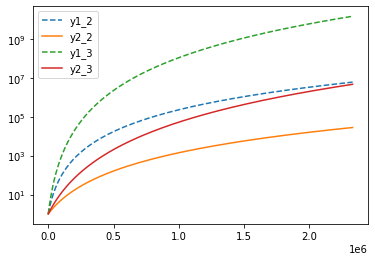

In [ ]:
rng = 500
x_1_cot = 400 
# x_2_cot = 21000
# x_2_cot = 400
x_2_cot = 2200
x_1_ber = x_1_cot*50 
# x_2_ber = x_2_cot*111
# x_2_ber = x_2_cot*70
x_2_ber = x_2_cot*13
#maxx / rng
print("minn", minn)
for i in range(2,4):

    x1 =np.linspace(x_1_cot, x_1_ber,rng)
    x2 =np.linspace(x_2_cot, x_2_ber,rng)
    def fun_cmpl (x,i): 
        if i == 0: return [math.log(_x)/math.log(min(x)) for _x  in x]
        if i == 1: return [_x/min(x) for _x  in x]
        if i == 2: return [(_x**3/min(x)**3)*_x/min(x) for _x  in x]
        if i == 3: return [(_x**3/min(x)**3)**2 for _x  in x]

    y1 = fun_cmpl(x1,i)
    y2 = fun_cmpl(x2,i)

    plt.plot(x,y1, label='y1_'+str(i), linestyle='dashed')
    plt.plot(x,y2, label='y2_'+str(i))
    plt.yscale('log')
    plt.legend()

# (y[0], x[0], math.log10(y[0])),(y[-1], x[-1], math.log(y[-1]), math.log10(y[-1]))

In [ ]:
# Plots: 
# Add 21*demand proportion line to n_pax + n_stops_in_net . Add x for cottbus and berlin and line
# Or should some kind of density measure be applied?

# Plot types
# Better have outcome variable on axis instead of color?=more clearly visible
# =if continous: add lines to color gradient s.t. you have contour lines or add markers along lines
# You could try to make it continous for each plot: add in between points for each dimension based on some average function. Best=get continous function to describe data.

# 2D
# 2D+color
# 2D multiline(1var, color gradient)
# 2D multiline(2vars,color gradient ^ alpha or line type)
# 3D+color
# 3D+color × multiple figures
# 3D+color+mutliple surface (maybe with arrows helping to understand the direction)
# 3D+color+mutliple surface (maybe with arrows helping to understand the direction at edge of picture)
# Add expansion path that hold a metric fixed
# n_stops_on_path
# 2D + color: n_pax + n_stops_in_net
# total_dist
# 2D + color: n_pax + n_stops_in_net
# 2D: n_stops_on_path = total_dist
# total_stop_time:
# 2D: n_stops_on_path
# 2D + color: n_pax + n_stops_in_net
# 3D + color: n_pax + time_first_pax + time_extra_pax (given n_stops_in_net)
# total_stop_time / pax
# 2D + color: n_pax + n_stops_in_net
# 3D + color: n_pax + time_first_pax + time_extra_pax (given n_stops_in_net)
# average_operating_speed
# 2D + color: n_pax + n_stops_in_net
# 4D + color: n_pax + time_first_pax + time_extra_pax (given n_stops_in_net)
# 5D + color: n_pax + time_first_pax + time_extra_pax + velocity (given n_stops_in_net)
# pax_served_per_operating_hour
# 2D + color: n_pax + n_stops_in_net
# 3D + color: n_pax + n_stops_in_net
# 5D + color: n_pax + time_first_pax + time_extra_pax + velocity (given n_stops_in_net)
# Optain combinations leading to 12 (cottbus), 24, 36 =cost efficieny, 48, 60 =lower cost
# def pax_trip_time_average() result from above only not normalized to 1 hour? *(n_pax -1)/(n_pax)
# If order matters path has to be traversed 1-2 times without 1 connection
# 2D + color: n_pax + n_stops_in_net
# 5D + color: n_pax + time_first_pax + time_extra_pax + velocity (given n_stops_in_net)


# Conversion from direct transport hours / vehicle operating hour
# PT speed comparison Cottbus vs Berlin
# PT travel time / divided by as-the-crow-flies distance (or shortest path through road network)
# mean occupancy:
# DRT cottbus: 4 on average, 20 mins on average, 12 passengers / operating hour, < 24 waypoints / operating hour
# assignment on the fly: up to 400 busses with paths scheduled until last drop-off of last boarded or confirmed passenger. Assume all request are dispatched 10 mins prior to requested departure. 7 mins average waiting time, 20 mins average in vehicle time. The longer schedules would then be 37 mins planned ahead. The shortest are not active or will shortly drop off their last passenger. The vehicle have an average load of 4 passengers and every second will have new pickup schedule within next 10 mins. Thus vehicles operate on paths connecting 4 + 2*50%=5 waypoints. So, how large of a detour is expected with respect to number of active vehicles assuming all connect 4 or 6 waypoints. 
# performance with respect to timing of request made in advance - keeping everything else constant
# it doesn’t really matter for on the fly assignments, as they only consider fixed schedules and disregard requests following
# it only matters in a short time frame before departure, where routing decision of a bus would have been altered to better reach pickup spot (-<=;=>-: going up or down is randomly chosen but could matter if pickup is on one side)
# performance when scaling up density of points - keeping point / vehicle ratio constant [define maximum total length / per vehicle as check whether another vehicle should be added]
# model performance would be strictly increasing with decreasing marginal benefits
# as model performance is increasing number of vehicles can be reduced (and capacity) increased
# this again increases marginal benefit of next vehicle
# at some point detour become less important than additional pick-up and drop-off times
# these could then be bundled to save time
# there exists a maximum reasonable vehicle load [from there a limit of reduction of distance to destination / vehicle hour]
# compare demand density, number of vehicles and capacity to Cottbus scenario
# performance when scaling up size of city - keeping density of demand (thus increasing total demand) and supply and average travel distance constant
# larger cities will need more buses to until marginal benefit is becoming low
# but larger cities will need less busses per user to fulfill demand
# performance when changing centrality / co-movement on the core-periphery dimension / correlation among neighbourhoods
# performance when explicitly giving score to low travel times
# solve tsp (simplify model, e.g. circles on which points are placed with probability on random angle)
# for directed pickup and drop off locations
# multiple vehicles
# think: demand density and network complexity: is there an interaction? Not a clear one.
